## 0. Goal 
Learn functions in Tim Sainburg's package AVGN
https://github.com/timsainb/avgn_paper

In [348]:
import os, sys, importlib, librosa, glob, h5py
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import noisereduce as nr
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42 

In [386]:
# import my utility script
Sainburg_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, Sainburg_script_path)
import umap_sainburg, hopkins
importlib.reload(umap_sainburg)

<module 'umap_sainburg' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/umap_sainburg.py'>

In [3]:
fd_save = '/mnt/z4/zz367/EphysMONAO/Analyzed/Figures/PearsonFinch/SainburgUMAP'

## 1. Make spectrograms

In [57]:
# define hyperparameters
hparams = umap_sainburg.HParams(
    n_fft = 1024,
    num_mel_bins = 32,
    mel_lower_edge_hertz=250,
    mel_upper_edge_hertz=12000,
    butter_lowcut = 250,
    butter_highcut = 12000,
    ref_level_db = 20,  # this is like the high bound of clim
    min_level_db = -50,  # this is like the low bound of clim
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    mask_spec_kwargs = {"spec_thresh": 0.4, "offset": 1e-10},
)

In [5]:
# use finch song as example
fd_wav = '/mnt/z4/zz367/EphysMONAO/Analyzed/Figures/PearsonFinch/VAE/Data/blk417'
fn_wav = os.path.join(fd_wav, 'blk417_44006.49904648_6_24_13_51_44.wav')
x, rate = librosa.load(fn_wav, sr=None)

In [6]:
# only look at regions with songs
t = np.array([1.5, 4.5])
i = t * rate
i = i.astype(np.int64)
data = x[i[0]:i[1]]

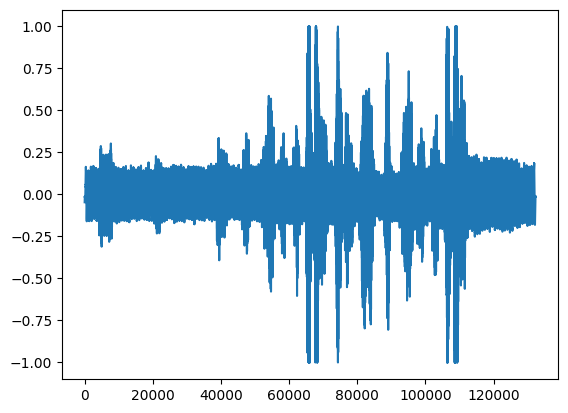

In [7]:
plt.plot(data)

### Filter raw wav signal

In [8]:
# convert data to float32 if needed
if np.issubdtype(type(data[0]), np.integer):
    data = umap_sainburg.int16_to_float32(data)

In [9]:
# save 
fn_save = os.path.join(fd_save, 'original.wav')
wavfile.write(fn_save, rate, data)

In [10]:
# bandpass filter
data = umap_sainburg.butter_bandpass_filter(data, hparams.butter_lowcut, hparams.butter_highcut, rate, order=5)
# save temporary file to check 
fn_save = os.path.join(fd_save, 'bandpass.wav')
wavfile.write(fn_save, rate, data)

In [11]:
# make spectrogram: no mel scaling
spec = umap_sainburg.make_spec(data, rate, hparams, mel_matrix=None, use_mel=False, norm_uint8=False)

In [12]:
print(data.shape, hparams.win_length_ms, hparams.hop_length_ms)

(132300,) 10 2


In [13]:
spec.shape

(513, 1504)

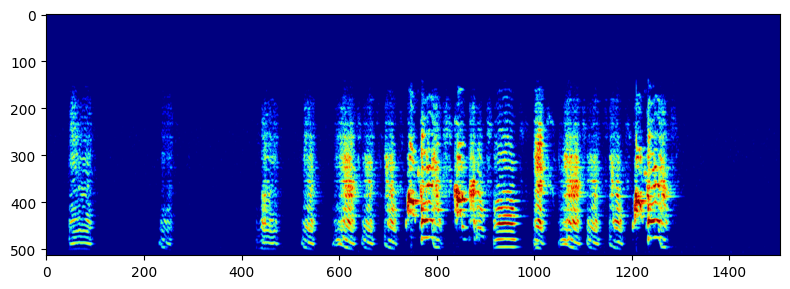

In [38]:
fig, ax = plt.subplots(figsize=(8, 3))
# Show image and scale it to fit the axes
ax.imshow(np.flipud(spec), aspect='auto', cmap='jet')  # 'auto' allows non-square pixels
# ax.axis('off')  # Optional: hide axes ticks and labels
plt.tight_layout()
plt.show()

In [28]:
# make spectrogram: with mel scaling
mel_matrix = umap_sainburg.prepare_mel_matrix(hparams, rate, return_numpy=True, GPU_backend=False)
spec2 = umap_sainburg.make_spec(data, rate, hparams, mel_matrix=mel_matrix, use_mel=True, norm_uint8=False)

In [29]:
mel_matrix.shape

(513, 32)

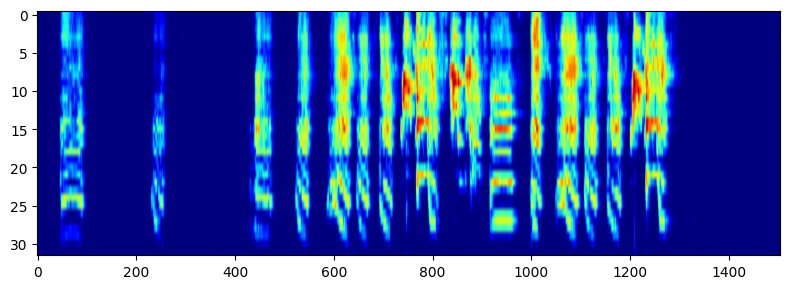

In [51]:
fig, ax = plt.subplots(figsize=(8, 3))
# Show image and scale it to fit the axes
ax.imshow(np.flipud(spec2), aspect='auto', cmap='jet')  # 'auto' allows non-square pixels
# ax.axis('off')  # Optional: hide axes ticks and labels
plt.tight_layout()
plt.show()

In [58]:
#mask threshold a spectrogram to be above some % of the maximum power
spec3 = umap_sainburg.mask_spec(spec2, **hparams.mask_spec_kwargs)

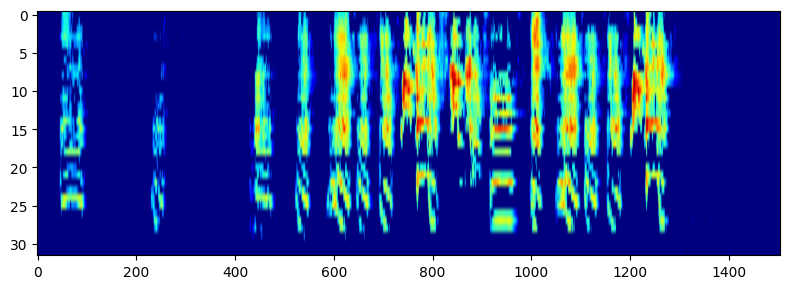

In [59]:
fig, ax = plt.subplots(figsize=(8, 3))
# Show image and scale it to fit the axes
ax.imshow(np.flipud(spec3), aspect='auto', cmap='jet')  # 'auto' allows non-square pixels
# ax.axis('off')  # Optional: hide axes ticks and labels
plt.tight_layout()
plt.show()

In [48]:
a = spec2.max(axis=0, keepdims=1)
a

array([[0.09027375, 0.06113837, 0.00217965, ..., 0.        , 0.        ,
        0.        ]])

In [49]:
a.shape

(1, 1504)

## 2. Stretch and pad syllables

In [237]:
fd_data = '/mnt/z4/zz367/EphysMONAO/Analyzed/Figures/PearsonFinch/VAE/Data'
birdID = 'blk417'
syl = ['a', 'b', 'c', 'd', 'e', 'f']
col_list = ['#e41a1c','#a65628','#4daf4a','#984ea3','#ff7f00','#f781bf']

In [119]:
# define hyperparameters, no masking
hparams = umap_sainburg.HParams(
    n_fft = 1024,
    num_mel_bins = 32,
    mel_lower_edge_hertz=250,
    mel_upper_edge_hertz=12000,
    butter_lowcut = 250,
    butter_highcut = 12000,
    ref_level_db = 20,  # this is like the high bound of clim
    min_level_db = -50,  # this is like the low bound of clim
    mask_spec = False,
    win_length_ms = 10,
    hop_length_ms = 2
)
# calculate mel scaling matrix
mel_matrix = umap_sainburg.prepare_mel_matrix(hparams, rate, return_numpy=True, GPU_backend=False)

In [68]:
# grab all wav files
fns_wav = sorted(glob.glob(os.path.join(fd_data, birdID, '*.wav')))
len(fns_wav)

200

### Make spectrograms of syllables

In [296]:
def ZZ_specFromWav_v1(fn, hparams, syl): 
    # given wav file and selected syllables, output spectrograms and meta info
    specs = []
    info = pd.DataFrame()
    # check if annotation file exist
    fn_label = fn.replace('.wav','.label.txt')
    if os.path.exists(fn_label):
        labels = np.genfromtxt(fn_label, dtype=str, delimiter=None, encoding='utf-8-sig')
        # check if it has target syllable
        idx = [ii for ii in range(labels.shape[0]) if labels[ii] in syl]
        if len(idx)>0:
            fn_time = fn_label.replace('.label.txt', '.time.txt')
            seg = np.loadtxt(fn_time, delimiter=',', dtype=int)
            # load wav file
            data, fs = librosa.load(fn, sr=None)
            # convert data to float32 if needed
            if np.issubdtype(type(data[0]), np.integer):
                data = umap_sainburg.int16_to_float32(data)
            # bandpass filter
            data = umap_sainburg.butter_bandpass_filter(data, hparams.butter_lowcut, hparams.butter_highcut, fs, order=5)
            # loop through target syllable
            for si in idx:
                x = data[seg[si,0]:seg[si,1]]
                # make spectrogram: with mel scaling
                spec = umap_sainburg.make_spec(x, fs, hparams, mel_matrix=mel_matrix, use_mel=True, norm_uint8=False)
                # spec = umap_sainburg.make_spec(x, fs, hparams, mel_matrix=mel_matrix, use_mel=False, norm_uint8=False)
                specs.append(spec)
                # record the meta info of this syllable
                row = pd.DataFrame([{'fn_wav':fn, 'istart':seg[si,0], 'iend':seg[si,1], 'label':labels[si]}])
                info = pd.concat([info, row], ignore_index=True)
    return(specs, info)

In [297]:
# loop through all wav files
with Parallel(n_jobs=48, verbose=5) as parallel:
    res = parallel(delayed(ZZ_specFromWav_v1)(fn, hparams, syl) for fn in fns_wav)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  64 out of 200 | elapsed:    1.7s remaining:    3.7s
[Parallel(n_jobs=48)]: Done 146 out of 200 | elapsed:    4.2s remaining:    1.6s
[Parallel(n_jobs=48)]: Done 200 out of 200 | elapsed:    4.9s finished


In [298]:
# flatten the result
temp = [aa[0] for aa in res]
specs = [arr for sublist in temp if sublist for arr in sublist]
df_list = [aa[1] for aa in res]
info = pd.concat([df for df in df_list if not df.empty], ignore_index=True)
print(len(specs), info.shape)

9006 (9006, 4)


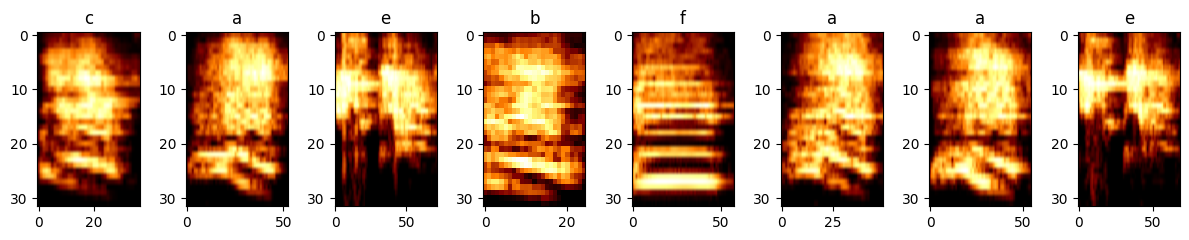

In [299]:
n = 8
random.seed(1118)
idx_rd = random.sample(range(len(specs)), n)
fig, axes = plt.subplots(1, n, figsize=(12, 2.5))
for ii in range(len(axes)):
    ax = axes[ii]
    ax.imshow(np.flipud(specs[idx_rd[ii]]), aspect='auto', cmap=plt.cm.afmhot)  # 'auto' allows non-square pixels
    ax.set_title(info.loc[idx_rd[ii], 'label'])
plt.tight_layout()
plt.show()

### Stretch and pad
Adapt from Sainburg code

In [300]:
log_scaling_factor = 10

In [301]:
# loop through all specs to stretch
with Parallel(n_jobs=48, verbose=5) as parallel:
    spec_resized = parallel(delayed(umap_sainburg.log_resize_spec)(spec, scaling_factor=log_scaling_factor) for spec in specs)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  67 tasks      | elapsed:    0.1s
[Parallel(n_jobs=48)]: Done 290 tasks      | elapsed:    0.1s
[Parallel(n_jobs=48)]: Done 1204 tasks      | elapsed:    0.2s
[Parallel(n_jobs=48)]: Done 5280 tasks      | elapsed:    0.5s
[Parallel(n_jobs=48)]: Done 7308 tasks      | elapsed:    0.6s
[Parallel(n_jobs=48)]: Done 9006 out of 9006 | elapsed:    0.8s finished


In [306]:
# determine paded shape
syll_lens = [np.shape(i)[1] for i in spec_resized]
# syll_lens = [np.shape(i)[1] for i in specs]   # no stretching
pad_length = np.max(syll_lens)
print(pad_length)

45


In [307]:
# loop through all resized specs to pad
with Parallel(n_jobs=48, verbose=5) as parallel:
    spec_padded = parallel(delayed(umap_sainburg.pad_spectrogram)(spec, pad_length=pad_length) for spec in spec_resized)
    # spec_padded = parallel(delayed(umap_sainburg.pad_spectrogram)(spec, pad_length=pad_length) for spec in specs)  # no stretch

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  69 tasks      | elapsed:    0.0s
[Parallel(n_jobs=48)]: Done 292 tasks      | elapsed:    0.1s
[Parallel(n_jobs=48)]: Done 1204 tasks      | elapsed:    0.2s
[Parallel(n_jobs=48)]: Done 5228 tasks      | elapsed:    0.4s
[Parallel(n_jobs=48)]: Done 7308 tasks      | elapsed:    0.5s
[Parallel(n_jobs=48)]: Done 9006 out of 9006 | elapsed:    0.7s finished


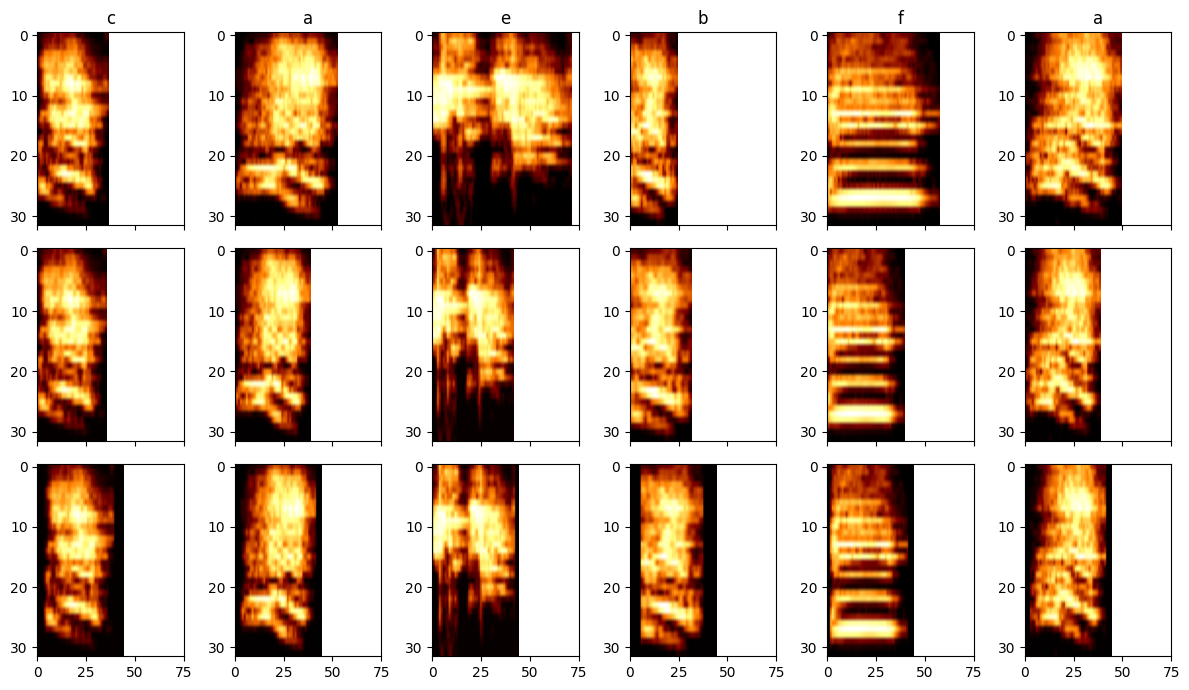

In [308]:
n = 6
random.seed(1118)
idx_rd = random.sample(range(len(specs)), n)
fig, axes = plt.subplots(3, n, figsize=(12, 7), sharex=True)
for ii in range(n):
    ax = axes[0][ii]
    ax.imshow(np.flipud(specs[idx_rd[ii]]), aspect='auto', cmap=plt.cm.afmhot)  # 'auto' allows non-square pixels
    ax.set_title(info.loc[idx_rd[ii], 'label'])
    ax.set_xlim([0, 75])
    ax = axes[1][ii]
    ax.imshow(np.flipud(spec_resized[idx_rd[ii]]), aspect='auto', cmap=plt.cm.afmhot)  # 'auto' allows non-square pixels
    ax.set_xlim([0, 75])
    ax = axes[2][ii]
    ax.imshow(np.flipud(spec_padded[idx_rd[ii]]), aspect='auto', cmap=plt.cm.afmhot)  # 'auto' allows non-square pixels
    ax.set_xlim([0, 75])
plt.tight_layout()
plt.show()

In [309]:
# save padded spectrograms as h5 file 
fn_h5 = os.path.join(fd_save, f'specPadded.mel.{birdID}.h5')
spec_win_all = np.stack(spec_padded, axis=0)
print(spec_win_all.shape)
with h5py.File(fn_h5, 'w') as f:
    f.create_dataset('spec_win_all', data=spec_win_all)

(9006, 32, 45)


In [310]:
# save meta info as well
fn_info = os.path.join(fd_save, f'specInfo.{birdID}.csv')
info.to_csv(fn_info)

In [311]:
info.shape

(9006, 4)

## 3. Run UMAP

In [312]:
# flatten the spectrogram
spec_flat = umap_sainburg.flatten_spectrograms(spec_win_all)
spec_flat.shape

(9006, 1440)

In [313]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.25, metric='euclidean', random_state=1118, verbose=True)
res = umap_model.fit_transform(spec_flat)

/home/zz367/miniconda3/envs/sainburg_umap/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zz367/miniconda3/envs/sainburg_umap/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(min_dist=0.25, n_jobs=1, random_state=1118, verbose=True)
Sat May 31 17:03:57 2025 Construct fuzzy simplicial set
Sat May 31 17:03:57 2025 Finding Nearest Neighbors
Sat May 31 17:03:57 2025 Building RP forest with 10 trees
Sat May 31 17:03:57 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Sat May 31 17:03:57 2025 Finished Nearest Neighbor Search
Sat May 31 17:03:57 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat May 31 17:04:05 2025 Finished embedding


In [314]:
# save embedding
embed = info.copy()
embed['umap1'] = res[:,0]
embed['umap2'] = res[:,1]
fn_embed = os.path.join(fd_save, f'umapEmbed.mel.{birdID}.csv')
embed.to_csv(fn_embed)

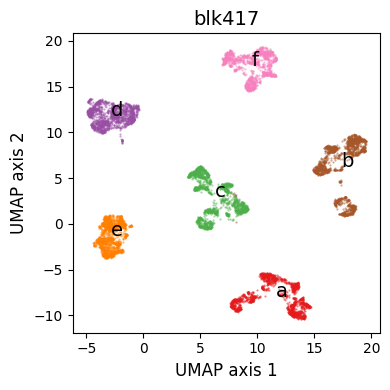

In [315]:
# plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 4])
for si, ss in enumerate(syl):
    embed_s = embed[embed['label']==ss]
    ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.5, c=col_list[si])
    # add syl label
    ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), ss, fontsize=14)
ax.set_title(birdID, fontsize=14)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, f'UMAP.mel.{birdID}.pdf')
fig.savefig(fn_fig)

In [321]:
# sample spectrograms surround embedding
spec_list = [spec_win_all[ii,:,:] for ii in range(spec_win_all.shape[0])]
print(len(spec_list), res.shape)

9006 (9006, 2)


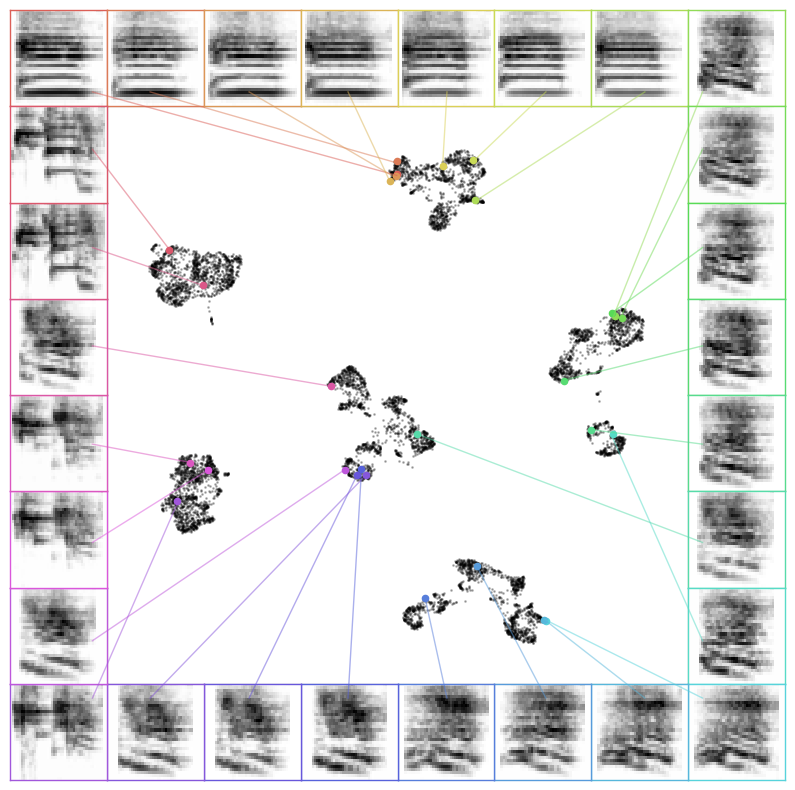

In [337]:
umap_sainburg.scatter_spec(
        res,
        spec_list,
        column_size=8,
        range_pad=0.1,
        #x_range = [-5.5,7],
        #y_range = [-10,10],
        pal_color="hls",
        color_points=True,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            #'labels': list(indv_df.labels.values),
            'alpha':0.25,
            's': 1,
            'show_legend': False,
            'equalize_axes':False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.5,
        },
        draw_lines=True
    );

## 4. Clustering

In [369]:
# what Sainburg used for bengalese finch
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(res.shape[0]* 0.01), # the smallest size we would expect a cluster to be
    min_samples=1, # larger values = more conservative clustering
)
clusterer.fit(res)
embed['hdbscan'] = clusterer.labels_

/home/zz367/miniconda3/envs/sainburg_umap/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zz367/miniconda3/envs/sainburg_umap/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [383]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(res.shape[0]* 0.05), # the smallest size we would expect a cluster to be
    min_samples=3, # larger values = more conservative clustering
)
clusterer.fit(res)
embed['hdbscan'] = clusterer.labels_

/home/zz367/miniconda3/envs/sainburg_umap/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/zz367/miniconda3/envs/sainburg_umap/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/tmp/ipykernel_475993/3244300520.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.5, c=col_long[hi])


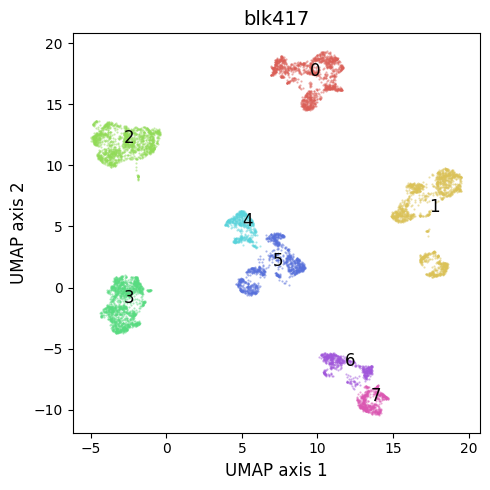

In [384]:
col_long = sns.color_palette('hls', n_colors=max(embed['hdbscan'])+1)
# plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for hi in range(0, max(embed['hdbscan'])+1):
    embed_s = embed[embed['hdbscan']==hi]
    ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.5, c=col_long[hi])
    # add syl label
    ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), hi, fontsize=12)
ax.set_title(birdID, fontsize=14)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
# fn_fig = os.path.join(fd_save, f'UMAP.mel.{birdID}.pdf')
# fig.savefig(fn_fig)

In [385]:
Counter(embed['hdbscan'])

Counter({1: 1552,
         2: 1514,
         3: 1452,
         0: 1387,
         5: 1011,
         6: 601,
         7: 552,
         4: 539,
         -1: 398})

## 5. Quantify clusterability with Hopkins metrics

In [389]:
hpk = hopkins.hopkins_statistic(res, m_prop_n=0.1, n_neighbors=1, distribution="uniform_convex_hull")
print(hpk)

0.9797521969827901


## 6. Quantify clustering quality with Silhoutte score

In [390]:
from sklearn.metrics import silhouette_score

In [398]:
sil = silhouette_score(res, embed['hdbscan'], random_state=1118, metric='euclidean')
print(sil)

0.6978745
